Note: This notebook does not care for focused hits or not. Just takes any circle size data! 

In [ ]:
import h5py 
import scipy 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy import stats
import os
import spts
import spts.camera
from spts.camera import CXDReader

In [ ]:
def combine_datafiles(filelist): 
    '''
    input:
    filelist - list of directory and filenames of the analysed and to be combined spts.cxi files
    
    output:
    [0]: hits_correctedall - array with length len(filelist)
    [1]: hitxall - array with length len(found particles)
    [2]: hityall - array with length len(found particles)
    [3]: hits_correctedall_single - array with length len(found particles)
    [4]: hitframeall - array with length len(found particles)
    - opens spts.cxi file
    - ignores hits with intensity < 0
    - NO FURTHER REMOVAL OF PARTICLES DONE HERE
    '''
    
    n_data = len(filelist)
    hits_corrected = []
    hits_correctedall = []
    hits_correctedall_single = []
    hitxall = []
    hityall = []
    hitframeall = []
    
    for i in range(n_data):
            
        f_name = filelist[i]
        print(i+1, '/',n_data, f_name)

        hits = 0  
        frames = 0 
        hit_intensity = 0 
        hit_intensities = np.empty(shape = (0)) 
        hit_x = np.empty(shape = (0)) # array for storing x-location of hit 
        hit_y = np.empty(shape = (0)) # array for storing y-location of hit 
        hit_frame = np.empty(shape = (0), dtype = int) # array for storing frame number of hits 

        f = h5py.File(f_name, 'r')

        frames += f['/5_detect/n'].shape[0] 
        hits += np.sum(f['/5_detect/n'])
        hits_per_frame = np.array(f["/5_detect/n"])

        #print('Number of frames:', frames) 
        #print('Number of raw hits:', hits) 

        for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
            for j in range(0, f['/5_detect/n'][i]): # particle counter 
                if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
                    hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
                    hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 
                    hit_frame = np.append(hit_frame, i)
                           
        a = np.array(f['/6_analyse/peak_sum']) 
        real_hits = np.sum((a > 0)) 
        #print('Number of real hits (intensity > 0):', real_hits) 
        #print()
        hit_intensities = np.append(hit_intensities, a[a > 0]) 

        sat_pix = np.array(f["/1_raw/saturated_n_pixels"])
        success_pix = np.array(f["/1_raw/success"])

        num_saturated_pixels = np.sum(sat_pix[sat_pix != 0])

        num_saturated_frames = np.sum(success_pix == 0)
        num_nonsaturated_frames = np.sum(success_pix == 1)

        fraction_saturated = num_saturated_frames / num_nonsaturated_frames

        #print("Number of saturated pixels: %s" % (num_saturated_pixels))
        print("Number of saturated frames: %s/%s" % (num_saturated_frames, frames))
        #print("Number of non-saturated frames: %s/%s" % (num_nonsaturated_frames,frames))
        #print("Percentage of saturated frames: %.4s%%" % (fraction_saturated*100))

        av_intensity = np.mean(hit_intensities) 
        med_intensity = np.median(hit_intensities) 
        std_intensity = np.std(hit_intensities) 
        min_intensity = np.min(hit_intensities) 
        max_intensity = np.max(hit_intensities) 
        mad_intensity = scipy.stats.median_abs_deviation(hit_intensities)

        hits_corrected, hitx, hity, hitframe = [], [], [], []
        hits_remain, hits_del = 0, 0
        for h in range(len(hit_intensities)): 
            hit_h = hit_intensities[h] 
            hx, hy, hf = hit_x[h], hit_y[h], hit_frame[h]
            if hit_h >= 0 : 
                hitx.append(hx) 
                hity.append(hy) 
                hitframe.append(hf)
                hits_corrected.append(hit_h) 
                hits_remain += 1
            else:
                hits_del += 1

        hits_corrected = np.array(hits_corrected)
        hitx = np.array(hitx) 
        hity = np.array(hity) 
        hitframe = np.array(hitframe)
            
        hits_correctedall = np.append(hits_correctedall, np.median(hits_corrected**(1/6))) # appends median sixths root intensity
        hits_correctedall_single = np.append(hits_correctedall_single, hits_corrected**(1/6)) # appends all sixths root hit intensities
        hitxall = np.append(hitxall, hitx) # all hit x-positions
        hityall = np.append(hityall, hity) # all hit y-positions
        hitframeall = np.append(hitframeall, hitframe) # all hit frame numbers
        
    return hits_correctedall, hitxall, hityall, hits_correctedall_single, hitframeall

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def files_from_folder(folderpath, log_path, exclude = []):
    #create list of files ending with "cxi" in folderpath
    files = [f for f in os.listdir(folderpath) if f.endswith('.cxi')]
    
    files = [f for f in files if f not in exclude]

    try:
        log = pd.read_csv(log_path)
    except Exception as e:
        print(f"Could not find log file at path: {log_path}. {e}")
        sys.exit(1)

    # Function to change the ending of the values
    def change_ending(value, old_ending, new_ending):
        if pd.notna(value) and value.endswith(old_ending):
            return value[:-len(old_ending)] + new_ending
        return value
    
    # Apply the function to specific columns
    log['File'] = log['File'].apply(change_ending, args=('.cdx', '.cxd'))

    files_dict = {}
    for file in files:
        row = log.loc[log['File'].str[:-4] == file[:9]]
        description = row['Description'].values[0]
        if description in files_dict:
            files_dict[description].append(folderpath + file)
        else:
            files_dict[description] = [folderpath + file]

    #sort dictionary by key alphabetically
    files_dict = dict(sorted(files_dict.items()))

    return files_dict

def combine_lists(files):
    particles_list = []
    for key in files:
        particles_list.append(combine_datafiles(files[key]))

    return particles_list


In [ ]:
files_w05 = files_from_folder(   "/home/rwendl/data/calib_he_jan23/spts_calib_he_jan23_w05/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

files_w25 = files_from_folder(   "/home/rwendl/data/calib_he_jan23/spts_calib_he_jan23_w25/",
                                                "/home/rwendl/data/consts/scatter_log.csv")

#print(files_w05)
#print(files_w25)

#print first element of dict files_w05
#print(files_w05[list(files_w05.keys())[0]])

particles_w05 = combine_lists(files_w05)
particles_w25 = combine_lists(files_w25)

[
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02365_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02366_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02367_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02368_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02369_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02370_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02371_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02372_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02373_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02374_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02375_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02376_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02377_ana_w05.cxi',
'/home/rwendl/data/analysis/raw_he_esi_ana_w05/data02378_ana_w05.cxi',
'/ho

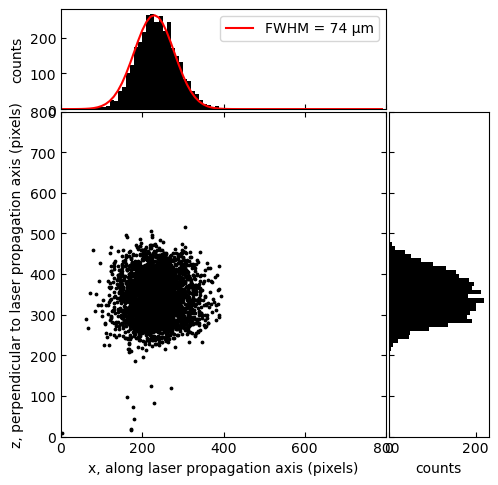

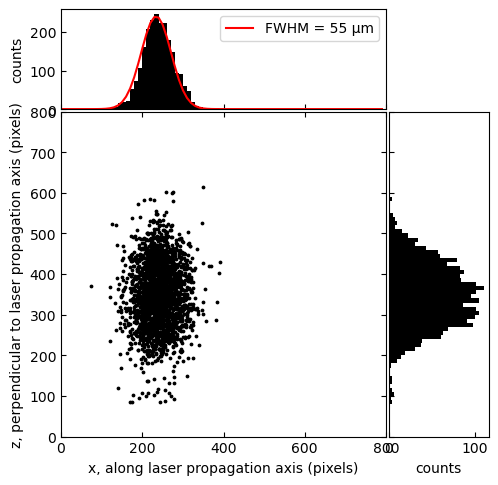

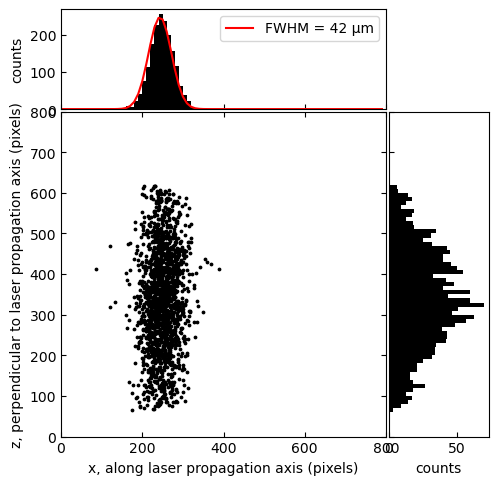

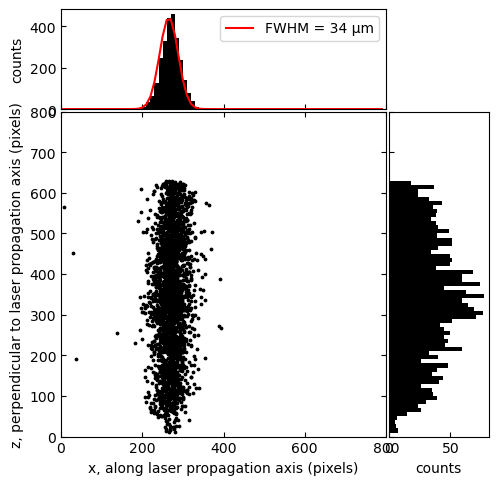

In [ ]:
particles = particles_w05

for m in range(len(particles)):
    sample = particles[m]
    
    x = sample[1]
    y = sample[2]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    fig = plt.figure(figsize=(5, 5))
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    axs = ax_scatter.scatter(x, y, s = 3, color = "black")

    # now determine nice limits by hand:
    binwidth = 10
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    ax_scatter.set_ylim((0, 800))
    ax_scatter.set_xlim((0, 800))
    ax_scatter.set_xlabel("x, along laser propagation axis (pixels)")
    ax_scatter.set_ylabel("z, perpendicular to laser propagation axis (pixels)")

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, fill = True, color = "black")
    ax_histy.hist(y, bins=bins, fill = True, color = "black", orientation='horizontal')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_histx.set_ylabel("counts")
    ax_histy.set_xlabel("counts")


    A, B = np.histogram(x, bins = int(800/binwidth), range = (0,800))
    xx, yy = B[:-1], A
    popt,pcov = curve_fit(Gauss, xx, yy, p0=[30, 200, 10])
    ax_histx.plot(xx, Gauss(xx, *popt), "-r", label = "FWHM = %s µm"%(int(abs(np.round(popt[2]*2.355*0.635)))))
    ax_histx.legend()


    C, D = np.histogram(y, bins = int(800/binwidth), range = (0,800))
    xx, yy = D[:-1], C

   # plt.savefig("%snmPS_unfilteredHist.pdf"%(diameter[i]))
    plt.show()
